In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

In [13]:
traindf = pd.read_hdf("../data/traindf_clean.hdf")
testdf = pd.read_hdf("../data/test_clean.hdf")

In [14]:
print(list(traindf.columns))
print(list(testdf.columns))

['prop_id', 'srch_id', 'position', 'price_quality', 'click_bool', 'booking_bool', 'price_usd', 'prop_location_score1', 'prop_location_score2', 'avg_price_propid', 'std_avg_price_propid', 'amount_hotels', 'avg_price_propid_after', 'std_avg_price_propid_after', 'price_rank', 'price_correction', 'locationscore2_rank', 'locationscore1_rank', 'importance']
['prop_id', 'srch_id', 'price_quality', 'price_usd', 'prop_location_score1', 'prop_location_score2', 'avg_price_propid', 'std_avg_price_propid', 'amount_hotels', 'avg_price_propid_after', 'std_avg_price_propid_after', 'price_rank', 'price_correction', 'locationscore2_rank', 'locationscore1_rank']


In [4]:
traindf = traindf.sort_values(by=['srch_id'])

In [15]:
# split label and other variables
x_train, y_train = traindf, traindf["importance"]

# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
#                                                     test_size=0.99, 
#                                                     random_state=42, 
#                                                     shuffle=False, 
#                                                     stratify = None)


# Drop columns that are to be predicted with importance (which is set to y_train)
x_train = x_train.drop(columns=["position", "importance", "booking_bool", "click_bool"])

# x_test is the total testset with all columns. 
x_test = testdf

In [6]:
# Check for correct shape and columns;
# x_train is probably much smaller because of downsampling: (50% of importance 5 and 1, 50% importance 0). 
# Number of columns in x_train and x_test must be equal!
print(x_train.shape, y_train.shape, x_test.shape)
print(list(x_train.columns))
print(list(x_test.columns))

(4958347, 15) (4958347,) (4959183, 14)
['prop_id', 'srch_id', 'price_quality', 'price_usd', 'prop_location_score1', 'prop_location_score2', 'avg_price_propid', 'std_avg_price_propid', 'amount_hotels', 'avg_price_propid_after', 'std_avg_price_propid_after', 'price_rank', 'price_correction', 'locationscore2_rank', 'locationscore1_rank']
['prop_id', 'srch_id', 'price_quality', 'price_usd', 'prop_location_score1', 'prop_location_score2', 'avg_price_propid', 'std_avg_price_propid', 'amount_hotels', 'avg_price_propid_after', 'price_rank', 'price_correction', 'locationscore2_rank', 'locationscore1_rank']


In [7]:
params = {'objective': 'rank:pairwise', 'learning_rate': 0.15,
          'gamma': 1, 'min_child_weight': 0.5,
          'max_depth': 8,  'n_estimators': 400}

# groups are equal to length of unique queries
query_lengths = x_train.groupby('srch_id').size().values

In [8]:
model = xgb.sklearn.XGBRanker(**params)
model.fit(x_train.drop(["prop_id", "srch_id"], axis=1), y_train, query_lengths, verbose=True)

[20:03:49] WARNING: /private/var/folders/bw/3x1jmlsx18n9l4m5200d38cc0000gn/T/pip-install-9rs4xnl_/xgboost/xgboost/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRanker(base_score=0.5, booster=None, colsample_bylevel=1, colsample_bynode=1,
          colsample_bytree=1, gamma=1, gpu_id=-1, importance_type='gain',
          interaction_constraints=None, learning_rate=0.15, max_delta_step=0,
          max_depth=10, min_child_weight=1.5, missing=nan,
          monotone_constraints=None, n_estimators=400, n_jobs=0,
          num_parallel_tree=1, objective='rank:pairwise', random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
          tree_method=None, validate_parameters=False, verbosity=None)

In [9]:
# Make fake column of positions to test score in ndcg scoring function,
# This is not needed for the testset, because there is nothing to check in the testset
# x_train["position_temp"] = x_train.groupby(['srch_id']).cumcount()+1

In [16]:
# x_train["position"] = y_train
predictions_sorted = []
prop_ids_sorted = []

# Sort predictions for each group SEPERATELY
for srchid, group in x_test.groupby('srch_id'):
    
    # Predictions for one search_id
    pred = model.predict(group.drop(["prop_id", "srch_id"], axis=1))
    
    prop_id = [x for _,x in sorted(zip(pred, group.prop_id), reverse=True)]
    prop_ids_sorted.append(prop_id)
    
# Flatten lists
predictions_sorted = [item for sublist in predictions_sorted for item in sublist]
prop_ids_sorted = [item for sublist in prop_ids_sorted for item in sublist]


In [17]:
x_test["prop_id"] = prop_ids_sorted

In [18]:
x_test.head()

,prop_id,srch_id,price_quality,price_usd,prop_location_score1,prop_location_score2,avg_price_propid,std_avg_price_propid,amount_hotels,avg_price_propid_after,std_avg_price_propid_after,price_rank,price_correction,locationscore2_rank,locationscore1_rank
0,61934,1,39.666667,119.0,2.94,0.0691,125.520757,11.710160,185.0,125.520757,11.710160,22.5,119.0,10.0,25.5
1,99484,1,39.333333,118.0,2.64,0.0843,117.532579,20.483788,252.0,117.532579,20.483788,21.0,118.0,13.0,11.0
2,24194,1,24.500000,49.0,2.71,0.0556,51.886600,4.464016,150.0,51.886600,4.464016,3.0,49.0,6.0,12.0
3,95031,1,47.666667,143.0,2.40,0.0561,133.987619,27.965448,147.0,133.987619,27.965448,25.0,143.0,7.0,8.0
4,28181,1,26.333333,79.0,2.94,0.2090,86.308224,14.807339,214.0,86.308224,14.807339,12.0,79.0,22.5,25.5


## Test set only: convert to csv for submission

In [19]:
filename = "submission9mei.csv"
final_df = x_test[["srch_id", "prop_id"]]
final_df.to_csv(filename, columns=["srch_id", "prop_id"], index=False)

In [20]:
# # Test if it worked
test = pd.read_csv(filename)
test.head()

,srch_id,prop_id
0,1,61934
1,1,99484
2,1,24194
3,1,95031
4,1,28181


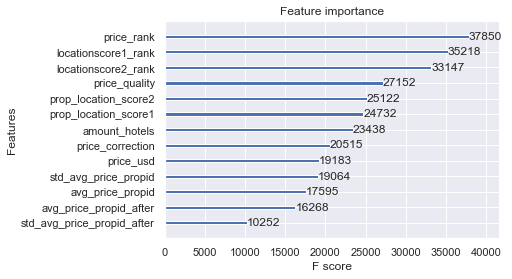

In [22]:
from sklearn.feature_selection import SelectFromModel
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

xgb.plot_importance(booster=model )
plt.show()